In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import psycopg2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from scipy.stats import stats
from scipy.stats import f_oneway
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3d projection
e_data = pd.read_csv('Ecommerce_Delivery_Analytics_New.csv')

In [27]:
class Ecommerce:
    """
    Ecommerce class for analyzing e-commerce delivery data.
    
    Attributes:
    -----------
    E_data : pd.DataFrame
        DataFrame containing e-commerce orders and delivery details.
    """
    def __init__(self, e_data):
        """
        Initialize the ecommerce class with a DataFrame.
        
        Parameters:
        -----------
        E_data : pd.DataFrame
            The e-commerce dataset.
        """
        self.e_data = e_data
        
    def dataframe(self):
        """
        Returns the stored DataFrame.
        
        Returns:
        --------
        pd.DataFrame
            The e-commerce dataset.
        """
        return self.e_data
        
    def shape(self):
        """
        Returns shape of the DataFrame (rows, columns).
        
        Returns:
        --------
        tuple
            Number of rows and columns.
        """
        return self.e_data.shape
        
    def type_conversion(self):
        """
        Converts columns to numeric types: 'Delivery Time (Minutes)',
        'Order Value (INR)', 'Service Rating'. Non-convertible values
        become NaN.
        """
        self.e_data['Delivery Time (Minutes)'] = pd.to_numeric(self.e_data['Delivery Time (Minutes)'], errors='coerce')
        self.e_data['Order Value (INR)'] = pd.to_numeric(self.e_data['Order Value (INR)'], errors='coerce')
        self.e_data['Service Rating'] = pd.to_numeric(self.e_data['Service Rating'], errors='coerce')
        
    def describing(self):
        """
        Produces descriptive statistics of numeric columns in the DataFrame.
        
        Returns:
        --------
        pd.DataFrame
            Summary statistics for numeric columns.
        """
        return self.e_data.describe()
        
    def total_columns(self):
        """
        Returns the list of all column names.
        
        Returns:
        --------
        pd.Index
            Column names in the DataFrame.
        """
        return self.e_data.columns
    
    def null_values(self):
        """
        Counts null values in each column.
        
        Returns:
        --------
        pd.Series
            Number of null values for each column.
        """
        return self.e_data.isnull().sum()
    
    def valuecounts(self):
        """
        Returns count of unique values in 'Platform' column.
        
        Returns:
        --------
        pd.DataFrame
            Counts of each unique platform.
        """
        return self.e_data['Platform'].value_counts().reset_index()
    
    @staticmethod
    def percent_yes(series):
        """
        Calculates the percentage of 'Yes' values in a series.
        
        Parameters:
        -----------
        series : pd.Series
            Series with 'Yes' or other values.
        
        Returns:
        --------
        float
            Percentage of 'Yes' values.
        """
        return 100 * (series == 'Yes').mean()
    
    def compute_platform_metrics(self):
        """
        Computes average delivery time, average service rating,
        % deliveries delayed, and % refunds requested per platform.
        
        Returns:
        --------
        pd.DataFrame
            Aggregated metrics grouped by platform.
        """
        platform_metrics = self.e_data.groupby('Platform').agg({
            'Delivery Time (Minutes)': 'mean',
            'Service Rating': 'mean',
            'Delivery Delay': self.percent_yes,
            'Refund Requested': self.percent_yes
        }).rename(columns={
            'Delivery Time (Minutes)': 'Avg Delivery Time (min)',
            'Service Rating': 'Avg Service Rating',
            'Delivery Delay': '% Deliveries Delayed',
            'Refund Requested': '% Refund Requested'
        }).round(2)
        return platform_metrics
    
    def category_delay_stats(self):
        """
        Calculates percentage of deliveries delayed by product category.
        
        Returns:
        --------
        pd.DataFrame
            Percentage delayed per product category.
        """
        category_delay = self.e_data.groupby('Product Category').agg({
            'Delivery Delay': self.percent_yes
        }).rename(columns={'Delivery Delay': '% Delayed'}).sort_values('% Delayed', ascending=False)
        return category_delay
    
    def Average_delivery_time(self):
        """
        Prints average delivery time grouped by delivery delay status.
        """
        delay_vs_time = self.e_data.groupby('Delivery Delay')['Delivery Time (Minutes)'].mean().round(2)
        print(delay_vs_time)
    
    def Average_service_rating(self):
        """
        Prints average delivery time grouped by service rating.
        """
        rating_vs_time = self.e_data.groupby('Service Rating')['Delivery Time (Minutes)'].mean()
        print(rating_vs_time)
    
    def minimum(self):
        """
        Returns minimum delivery time per customer sorted ascending.
        
        Returns:
        --------
        pd.DataFrame
            Customers and their minimum delivery times.
        """
        return self.e_data.groupby('Customer ID')['Delivery Time (Minutes)'].min().reset_index().sort_values(by='Delivery Time (Minutes)', ascending=True)


    def Chi_Square_test(self, col1, col2):
        """
        Perform Chi-Square test of independence between two categorical columns.

        Parameters:
        -----------
        col1 : str
            Name of the first categorical column.
        col2 : str
            Name of the second categorical column.

        Returns:
        --------
        dict
            Dictionary containing chi-square statistic, p-value, degrees of freedom,
            and expected frequencies matrix.
        """
        contingency_table = pd.crosstab(self.e_data[col1], self.e_data[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        return {
            'chi2_statistic': chi2,
            'p_value': p,
            'degrees_of_freedom': dof,
            'expected_freq': expected
        }
    def line_plot(self):
        """
        Displays a line plot for delivery time grouped by product category.
        """
        plt.figure(figsize=(15,10))
        sns.lineplot(data=self.e_data, x="Product Category", y="Delivery Time (Minutes)")
        plt.show()
    
    def scatter_plot(self):
        """
        Displays a scatter plot of order value vs delivery time.
        """
        plt.figure(figsize=(20,40))
        sns.scatterplot(data=self.e_data, x="Order Value (INR)", y="Delivery Time (Minutes)")
        plt.show()
    
    def bar_plot(self):
        """
        Displays a bar plot of average service rating by platform.
        """
        avg_ratings = self.e_data.groupby("Platform")["Service Rating"].mean().reset_index()
        sns.barplot(data=avg_ratings, x="Platform", y="Service Rating")
        plt.title("Average Service Rating by Platform")
        plt.show()
    
    def violin_plot(self):
        """
        Displays a violin plot showing distribution of service rating by platform.
        """
        sns.violinplot(data=self.e_data, x="Platform", y="Service Rating")
        plt.title("Service Rating by Platform")
        plt.show()
    
    def histogram(self, col):
        """
        Displays a histogram for a specified column.
        
        Parameters:
        -----------
        col : str
            The column name to plot the histogram for.
        """
        sns.histplot(data=self.e_data, x=col, bins=20, color="skyblue")
        plt.show()
    
    def correlation(self):
        """
        Displays a heatmap of correlations among order value, service rating, and delivery time.
        """
        sns.heatmap(self.e_data[['Order Value (INR)', 'Service Rating', 'Delivery Time (Minutes)']].corr(), annot=True)
        plt.show()
    
    def piechart(self):
        """
        Displays a pie chart of order share by platform.
        """
        platform_counts = self.e_data['Platform'].value_counts()
        plt.pie(
            platform_counts, 
            labels=platform_counts.index, 
            autopct='%1.1f%%', 
            startangle=140
        )
        plt.title("Order Share by Platform")
        plt.axis('equal')  # Ensures the pie is circular
        plt.show()

    def ANOVA(self):
        """
        Perform ANOVA tests for all numeric columns grouped by 'Refund Requested'.
        Prints F-statistic and p-value indicating whether group means differ significantly.
    
        Requires:
        ---------
        The column 'Refund Requested' must be categorical/grouping variable.
        """
        continuous_vars = self.e_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
        target = 'Refund Requested'
        for col in continuous_vars:
            # Drop rows where either current col or target has null values
            data = self.e_data[[col, target]].dropna()
    
            # Prepare groups based on the target's unique values
            groups = [group[col].values for name, group in data.groupby(target)]
    
            if len(groups) > 1:  # ANOVA requires at least two groups
                f_stat, p_val = stats.f_oneway(*groups)
                print(f"ANOVA for {col} by {target}: F = {f_stat:.3f}, p = {p_val:.3e}")
            else:
                print(f"Insufficient groups for {col} to perform ANOVA.")

    def plot_numeric_correlation(self, figsize=(12, 10), cmap='coolwarm'):
        """
        Plot a heatmap of the correlation matrix for numerical columns.

        Parameters:
        -----------
        figsize : tuple, optional
            Figure size (width, height). Default is (12,10).
        cmap : str, optional
            Color map for the heatmap. Default is 'coolwarm'.
        """
        numeric_df = self.e_data.select_dtypes(include=np.number)
        corr = numeric_df.corr()
        plt.figure(figsize=figsize)
        sns.heatmap(corr, annot=True, cmap=cmap)
        plt.show()


    @staticmethod
    def infer_sql_type(dtype):
        if pd.api.types.is_integer_dtype(dtype):
            return "INT"
        elif pd.api.types.is_float_dtype(dtype):
            return "FLOAT"
        elif pd.api.types.is_bool_dtype(dtype):
            return "BOOLEAN"
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            return "TIMESTAMP"
        else:
            return "TEXT"
    
    def generate_create_table_statement(self, table_name="Ecommerce_Delivery_Analytics_New"):
        """
        Generates SQL CREATE TABLE statement based on DataFrame column dtypes.
        
        Parameters:
        -----------
        table_name : str
            Name of the SQL table to create.
        
        Returns:
        --------
        str
            SQL CREATE TABLE statement.
        """
        columns = self.e_data.dtypes
        sql_columns = ",\n    ".join([f'"{col}" {self.infer_sql_type(dtype)}' for col, dtype in columns.items()])
        create_stmt = f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        {sql_columns}
    );
    """
        return create_stmt


    def save_to_postgres(self, conn_params, table_name="Ecommerce_Delivery_Analytics_New"):
        """
        Creates table and inserts DataFrame records into PostgreSQL.
        
        Parameters:
        -----------
        conn_params : dict
            Dictionary with keys: dbname, user, password, host, port.
        table_name : str, optional
            Name of the PostgreSQL table, default "Ecommerce_Delivery_Analytics_New".
        """
        create_stmt = self.generate_create_table_statement(table_name)
        
        try:
            conn = psycopg2.connect(**conn_params)
            cur = conn.cursor()
            
            # Create the table
            cur.execute(create_stmt)
            conn.commit()
            
            # Prepare insert statement
            columns = list(self.e_data.columns)
            placeholders = ', '.join(['%s'] * len(columns))
            insert_stmt = f"""
            INSERT INTO {table_name} ({', '.join(['"{}"'.format(col) for col in columns])})
            VALUES ({placeholders})
            """
            
            # Insert data row by row
            for _, row in self.e_data.iterrows():
                cur.execute(insert_stmt, tuple(row))
            conn.commit()
            
            cur.close()
            conn.close()
            print(f"Data inserted successfully into table {table_name}")
            
        except Exception as e:
            print(f"Error during PostgreSQL operation: {e}")
# Usage
obj_e = Ecommerce(e_data) 

In [3]:
obj_e.dataframe()

,Order ID,Customer ID,Platform,Delivery Time (Minutes),Product Category,Order Value (INR),Customer Feedback,Service Rating,Delivery Delay,Refund Requested
0,ORD000001,CUST2824,JioMart,30,Fruits & Vegetables,382,"Fast delivery, great service!",5,No,No
1,ORD000002,CUST1409,Blinkit,16,Dairy,279,Quick and reliable!,5,No,No
2,ORD000003,CUST5506,JioMart,25,Beverages,599,Items missing from order.,2,No,Yes
3,ORD000004,CUST5012,JioMart,42,Beverages,946,Items missing from order.,2,Yes,Yes
4,ORD000005,CUST4657,Blinkit,30,Beverages,334,"Fast delivery, great service!",5,No,No
...,...,...,...,...,...,...,...,...,...,...
99995,ORD099996,CUST5324,JioMart,24,Dairy,289,Packaging could be better.,3,No,No
99996,ORD099997,CUST1677,JioMart,19,Snacks,322,Good quality products.,4,No,No
99997,ORD099998,CUST8198,JioMart,41,Dairy,135,"Fast delivery, great service!",5,Yes,No
99998,ORD099999,CUST9975,JioMart,31,Grocery,973,Quick and reliable!,5,No,No


In [4]:
obj_e.shape()

(100000, 10)

In [5]:
obj_e.type_conversion()

In [6]:
obj_e.describing()

,Delivery Time (Minutes),Order Value (INR),Service Rating
count,100000.000000,100000.000000,100000.000000
mean,29.536140,590.994400,3.240790
std,9.958933,417.409058,1.575962
min,5.000000,50.000000,1.000000
25%,23.000000,283.000000,2.000000
50%,30.000000,481.000000,3.000000
75%,36.000000,770.000000,5.000000
max,76.000000,2000.000000,5.000000


In [7]:
obj_e.valuecounts()

,Platform,count
0,Swiggy Instamart,33449
1,Blinkit,33424
2,JioMart,33127


In [8]:
obj_e.total_columns()

Index(['Order ID', 'Customer ID', 'Platform', 'Delivery Time (Minutes)',
       'Product Category', 'Order Value (INR)', 'Customer Feedback',
       'Service Rating', 'Delivery Delay', 'Refund Requested'],
      dtype='object')

In [9]:
obj_e.null_values()

Order ID                   0
Customer ID                0
Platform                   0
Delivery Time (Minutes)    0
Product Category           0
Order Value (INR)          0
Customer Feedback          0
Service Rating             0
Delivery Delay             0
Refund Requested           0
dtype: int64

In [10]:
obj_e.valuecounts()

,Platform,count
0,Swiggy Instamart,33449
1,Blinkit,33424
2,JioMart,33127


In [11]:
obj_e.compute_platform_metrics()

,Avg Delivery Time (min),Avg Service Rating,% Deliveries Delayed,% Refund Requested
Platform,,,,
Blinkit,29.47,3.23,13.38,45.93
JioMart,29.63,3.25,13.83,45.82
Swiggy Instamart,29.50,3.24,13.81,45.71


In [12]:
obj_e.category_delay_stats()


,% Delayed
Product Category,
Grocery,13.819681
Fruits & Vegetables,13.768639
Dairy,13.715370
Personal Care,13.633339
Snacks,13.570787
Beverages,13.522013


In [13]:
obj_e.Average_delivery_time()

Delivery Delay
No     27.00
Yes    45.56
Name: Delivery Time (Minutes), dtype: float64


In [14]:
obj_e.Average_service_rating()

Service Rating
1    29.518766
2    29.556592
3    29.428349
4    29.617538
5    29.531922
Name: Delivery Time (Minutes), dtype: float64


In [15]:
obj_e.minimum()

,Customer ID,Delivery Time (Minutes)
54,CUST1054,5
8559,CUST9559,5
81,CUST1081,5
74,CUST1074,5
7820,CUST8820,5
...,...,...
5769,CUST6769,32
3576,CUST4576,33
1187,CUST2187,33
239,CUST1239,34


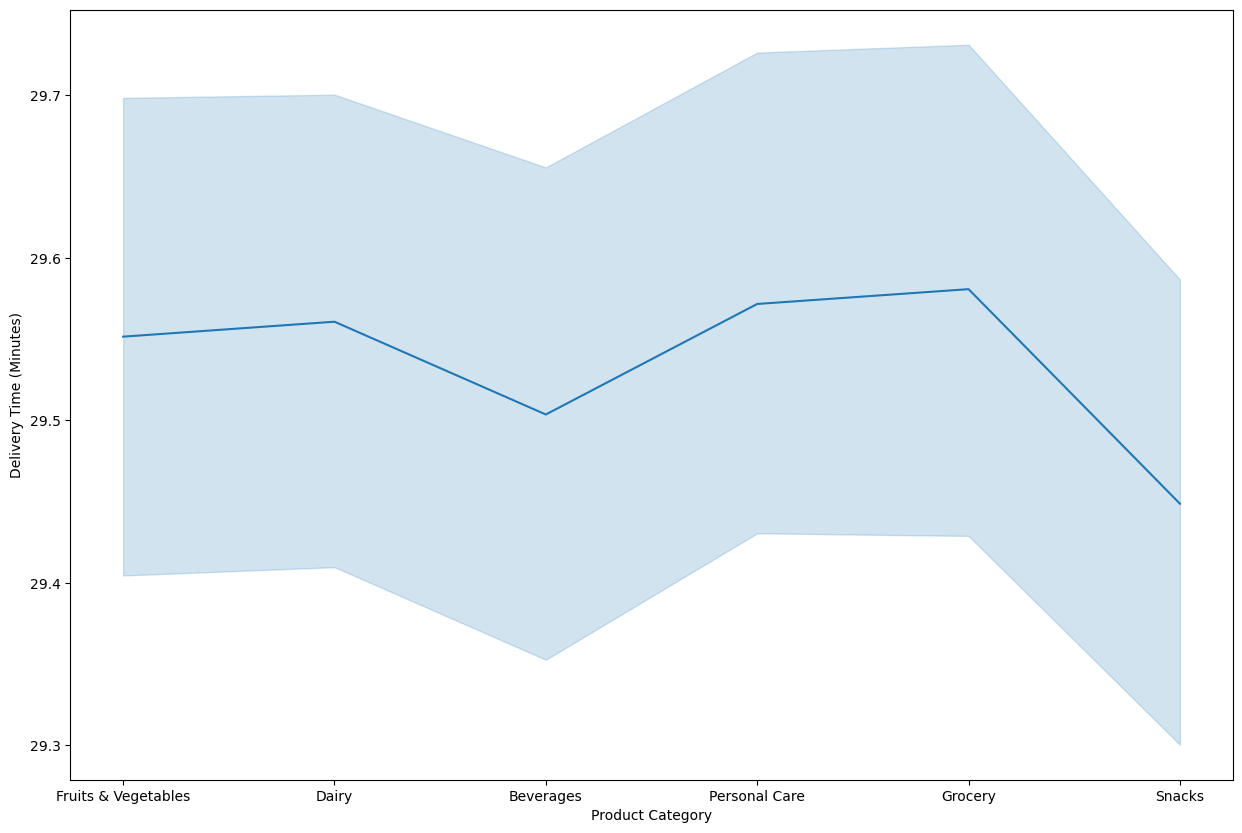

In [16]:
obj_e.line_plot()

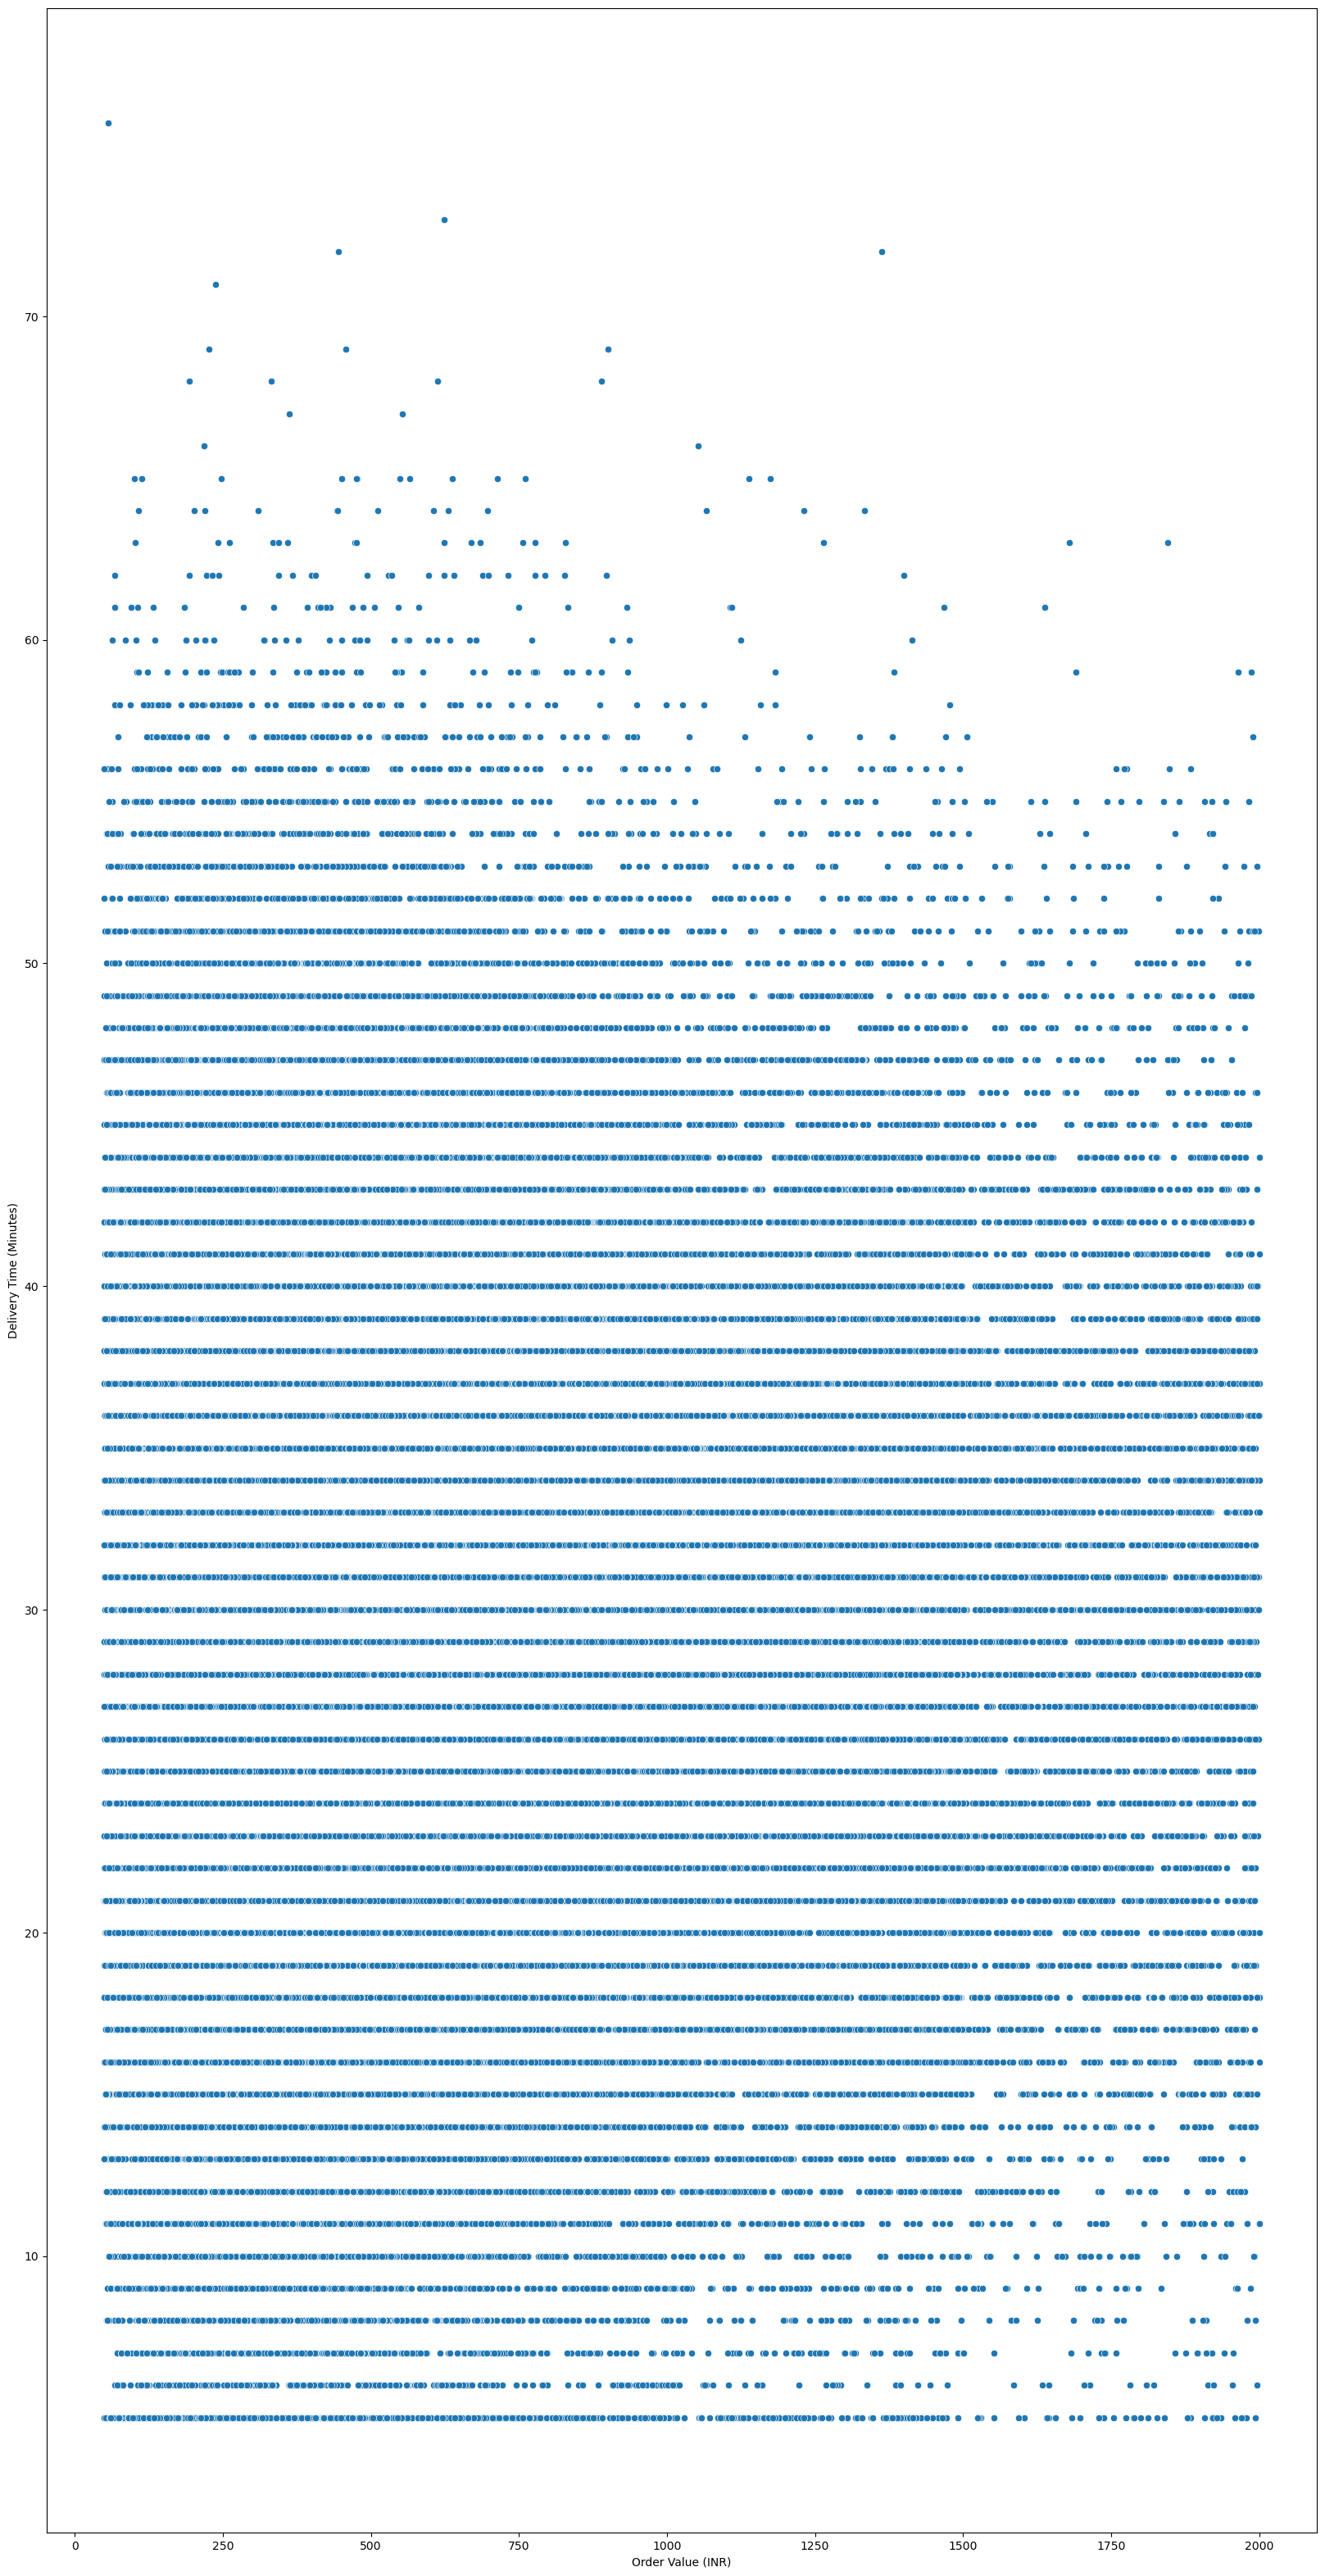

In [17]:
obj_e.scatter_plot()

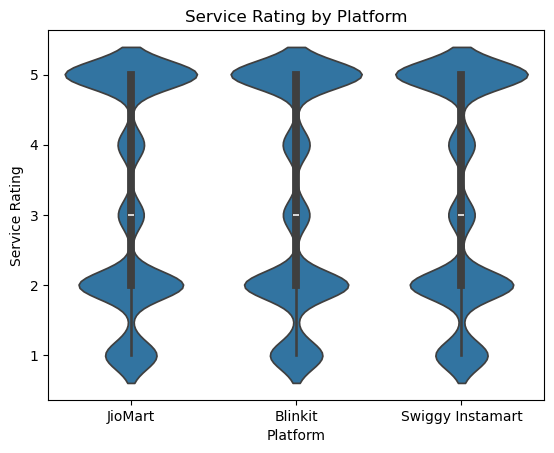

In [18]:
obj_e.violin_plot()

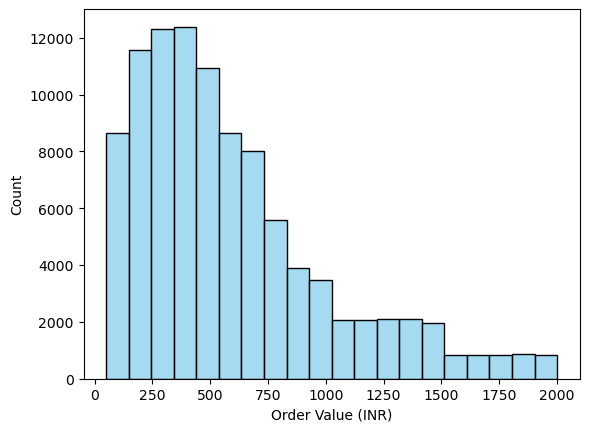

In [19]:
obj_e.histogram("Order Value (INR)")

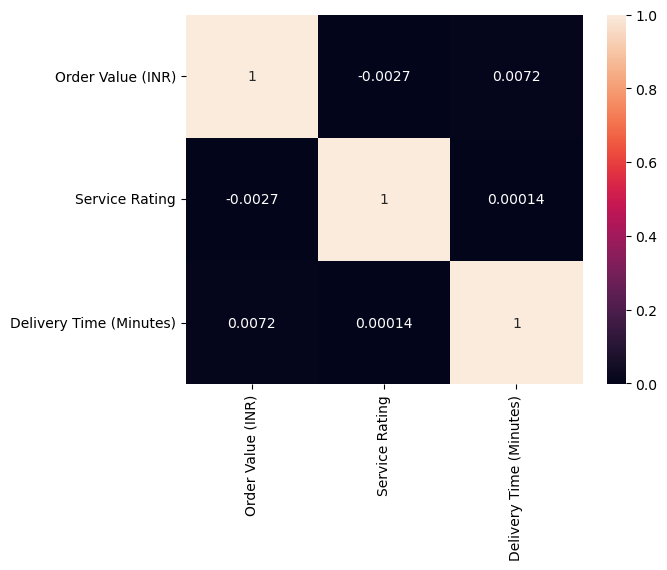

In [20]:
obj_e.correlation()

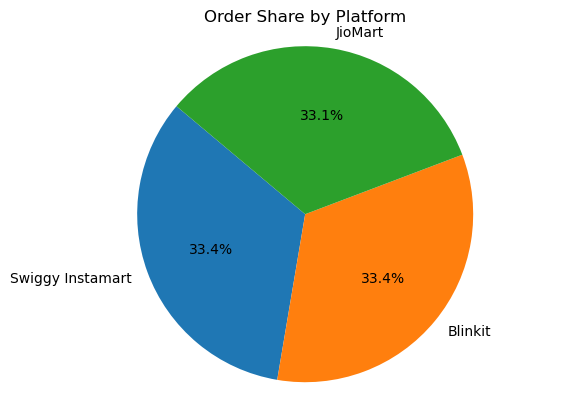

In [21]:
obj_e.piechart()

In [22]:
obj_e.Chi_Square_test('Platform','Product Category')

{'chi2_statistic': np.float64(6.689176343244628),
 'p_value': np.float64(0.7544265224965951),
 'degrees_of_freedom': 10,
 'expected_freq': array([[5526.99264, 5634.28368, 5559.07968, 5594.17488, 5525.98992,
         5583.4792 ],
        [5477.88072, 5584.21839, 5509.68264, 5544.46599, 5476.88691,
         5533.86535],
        [5531.12664, 5638.49793, 5563.23768, 5598.35913, 5530.12317,
         5587.65545]])}

In [23]:
obj_e.ANOVA()

ANOVA for Delivery Time (Minutes) by Refund Requested: F = 0.053, p = 8.187e-01
ANOVA for Order Value (INR) by Refund Requested: F = 0.702, p = 4.020e-01
ANOVA for Service Rating by Refund Requested: F = 539219.357, p = 0.000e+00


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17416\2535071266.py:288: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17416\2535071266.py:288: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17416\2535071266.py:288: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  f_stat, p_val = stats.f_oneway(*groups)


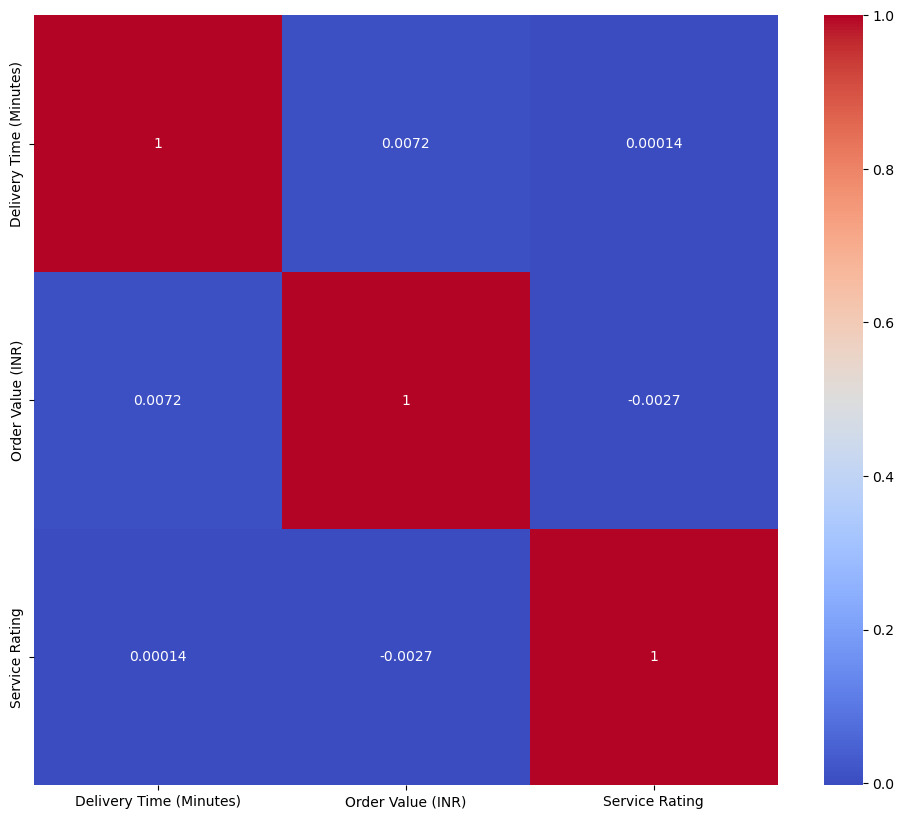

In [24]:
obj_e.plot_numeric_correlation()

In [28]:

print(obj_e.generate_create_table_statement())



    CREATE TABLE IF NOT EXISTS Ecommerce_Delivery_Analytics_New (
        "Order ID" TEXT,
    "Customer ID" TEXT,
    "Platform" TEXT,
    "Delivery Time (Minutes)" INT,
    "Product Category" TEXT,
    "Order Value (INR)" INT,
    "Customer Feedback" TEXT,
    "Service Rating" INT,
    "Delivery Delay" TEXT,
    "Refund Requested" TEXT
    );
    


In [29]:
conn_params = {
    'dbname': "postgres",
    'user': "postgres",
    'password': "postgres",
    'host': "localhost",
    'port': "5432"
}
obj_e.save_to_postgres(conn_params)


Data inserted successfully into table Ecommerce_Delivery_Analytics_New
